# 对地理坐标进行聚类

**说明:**

将 `places.txt` 和 `Portland.png` 放在当前目录下。

In [1]:
from numpy import *

## K-均值聚类支持函数

In [2]:
def distEclud(vecA, vecB):
    return sqrt(sum(power(vecA - vecB, 2))) #la.norm(vecA-vecB)

def randCent(dataSet, k):
    n = shape(dataSet)[1]
    centroids = mat(zeros((k,n)))#create centroid mat
    for j in range(n):#create random cluster centers, within bounds of each dimension
        minJ = min(dataSet[:,j]) 
        rangeJ = float(max(dataSet[:,j]) - minJ)
        centroids[:,j] = mat(minJ + rangeJ * random.rand(k,1))
    return centroids

## K-均值聚类算法

In [3]:
def kMeans(dataSet, k, distMeas=distEclud, createCent=randCent):
    m = shape(dataSet)[0]
    clusterAssment = mat(zeros((m,2)))#create mat to assign data points 
                                      #to a centroid, also holds SE of each point
    centroids = createCent(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m):#for each data point assign it to the closest centroid
            minDist = inf; minIndex = -1
            for j in range(k):
                distJI = distMeas(centroids[j,:],dataSet[i,:])
                if distJI < minDist:
                    minDist = distJI; minIndex = j
            if clusterAssment[i,0] != minIndex: clusterChanged = True
            clusterAssment[i,:] = minIndex,minDist**2
        print(centroids)
        for cent in range(k):#recalculate centroids
            ptsInClust = dataSet[nonzero(clusterAssment[:,0].A==cent)[0]]#get all the point in this cluster
            centroids[cent,:] = mean(ptsInClust, axis=0) #assign centroid to mean 
    return centroids, clusterAssment

## 二分 K-均值算法

In [4]:
def biKmeans(dataSet, k, distMeas=distEclud):
    m = shape(dataSet)[0]
    clusterAssment = mat(zeros((m,2)))
    centroid0 = mean(dataSet, axis=0).tolist()[0]
    centList =[centroid0] #create a list with one centroid
    for j in range(m):#calc initial Error
        clusterAssment[j,1] = distMeas(mat(centroid0), dataSet[j,:])**2
    while (len(centList) < k):
        lowestSSE = inf
        for i in range(len(centList)):
            ptsInCurrCluster = dataSet[nonzero(clusterAssment[:,0].A==i)[0],:]#get the data points currently in cluster i
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas)
            sseSplit = sum(splitClustAss[:,1])#compare the SSE to the currrent minimum
            sseNotSplit = sum(clusterAssment[nonzero(clusterAssment[:,0].A!=i)[0],1])
            print("sseSplit, and notSplit: ",sseSplit,sseNotSplit)
            if (sseSplit + sseNotSplit) < lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                lowestSSE = sseSplit + sseNotSplit
        bestClustAss[nonzero(bestClustAss[:,0].A == 1)[0],0] = len(centList) #change 1 to 3,4, or whatever
        bestClustAss[nonzero(bestClustAss[:,0].A == 0)[0],0] = bestCentToSplit
        print('the bestCentToSplit is: ',bestCentToSplit)
        print('the len of bestClustAss is: ', len(bestClustAss))
        centList[bestCentToSplit] = bestNewCents[0,:].tolist()[0]#replace a centroid with two best centroids 
        centList.append(bestNewCents[1,:].tolist()[0])
        clusterAssment[nonzero(clusterAssment[:,0].A == bestCentToSplit)[0],:]= bestClustAss#reassign new clusters, and SSE
    return mat(centList), clusterAssment

## 球面距离计算

In [5]:
def distSLC(vecA, vecB):#Spherical Law of Cosines
    a = sin(vecA[0,1]*pi/180) * sin(vecB[0,1]*pi/180)
    b = cos(vecA[0,1]*pi/180) * cos(vecB[0,1]*pi/180) * \
                      cos(pi * (vecB[0,0]-vecA[0,0]) /180)
    return arccos(a + b)*6371.0 #pi is imported with numpy

## 数据导入函数

In [6]:
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    dataMat = []                #assume last column is target value
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float,curLine)) #map all elements to float()
        dataMat.append(fltLine)
    return dataMat

## 聚类及簇绘图函数

In [7]:
import matplotlib
import matplotlib.pyplot as plt
def clusterClubs(numClust=5):
    datList = []
    for line in open('places.txt').readlines():
        lineArr = line.split('\t')
        datList.append([float(lineArr[4]), float(lineArr[3])])
    datMat = mat(datList)
    myCentroids, clustAssing = biKmeans(datMat, numClust, distMeas=distSLC)
    fig = plt.figure()
    rect=[0.1,0.1,0.8,0.8]
    scatterMarkers=['s', 'o', '^', '8', 'p', \
                    'd', 'v', 'h', '>', '<']
    axprops = dict(xticks=[], yticks=[])
    ax0=fig.add_axes(rect, label='ax0', **axprops)
    imgP = plt.imread('Portland.png')
    ax0.imshow(imgP)
    ax1=fig.add_axes(rect, label='ax1', frameon=False)
    for i in range(numClust):
        ptsInCurrCluster = datMat[nonzero(clustAssing[:,0].A==i)[0],:]
        markerStyle = scatterMarkers[i % len(scatterMarkers)]
        ax1.scatter(ptsInCurrCluster[:,0].flatten().A[0], ptsInCurrCluster[:,1].flatten().A[0], marker=markerStyle, s=90)
    ax1.scatter(myCentroids[:,0].flatten().A[0], myCentroids[:,1].flatten().A[0], marker='+', s=300)
    plt.show()

[[-122.64973039   45.56231053]
 [-122.68117413   45.41970179]]
[[-122.61260746   45.53042158]
 [-122.69000412   45.45689647]]
[[-122.60390649   45.52793885]
 [-122.72366337   45.46052519]]
[[-122.5978824    45.52454438]
 [-122.73504547   45.47487376]]
sseSplit, and notSplit:  3436.25408356 0.0
the bestCentToSplit is:  0
the len of bestClustAss is:  69
[[-122.43063728   45.44209414]
 [-122.44220459   45.47010425]]
[[-122.376304     45.430319  ]
 [-122.60222708   45.52639194]]
[[-122.4009285    45.46897   ]
 [-122.60576056   45.52676736]]
[[-122.42811233   45.485694  ]
 [-122.60827649   45.52692298]]
[[-122.4568086    45.4961344 ]
 [-122.61289026   45.52756672]]
[[-122.4927627    45.4967901 ]
 [-122.6229109    45.53115255]]
[[-122.50706986   45.50135379]
 [-122.63133966   45.53308829]]
[[-122.51784582   45.50240459]
 [-122.63675731   45.535298  ]]
[[-122.52181039   45.50142783]
 [-122.63815582   45.53678256]]
sseSplit, and notSplit:  1163.36449048 1123.89900786
[[-122.8261996    45.48416

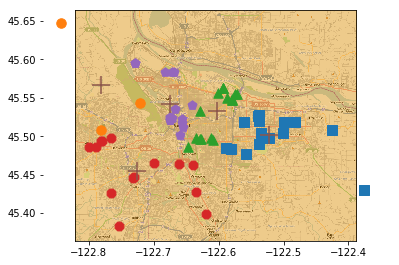

In [8]:
clusterClubs(5)

In [1]:
import KMeans
np=KMeans.loadDataSet('testSet.txt')
np

[[1.658985, 4.285136],
 [-3.453687, 3.424321],
 [4.838138, -1.151539],
 [-5.379713, -3.362104],
 [0.972564, 2.924086],
 [-3.567919, 1.531611],
 [0.450614, -3.302219],
 [-3.487105, -1.724432],
 [2.668759, 1.594842],
 [-3.156485, 3.191137],
 [3.165506, -3.999838],
 [-2.786837, -3.099354],
 [4.208187, 2.984927],
 [-2.123337, 2.943366],
 [0.704199, -0.479481],
 [-0.39237, -3.963704],
 [2.831667, 1.574018],
 [-0.790153, 3.343144],
 [2.943496, -3.357075],
 [-3.195883, -2.283926],
 [2.336445, 2.875106],
 [-1.786345, 2.554248],
 [2.190101, -1.90602],
 [-3.403367, -2.778288],
 [1.778124, 3.880832],
 [-1.688346, 2.230267],
 [2.592976, -2.054368],
 [-4.007257, -3.207066],
 [2.257734, 3.387564],
 [-2.679011, 0.785119],
 [0.939512, -4.023563],
 [-3.674424, -2.261084],
 [2.046259, 2.735279],
 [-3.18947, 1.780269],
 [4.372646, -0.822248],
 [-2.579316, -3.497576],
 [1.889034, 5.1904],
 [-0.798747, 2.185588],
 [2.83652, -2.658556],
 [-3.837877, -3.253815],
 [2.096701, 3.886007],
 [-2.709034, 2.923887],

[[-122.58608906   45.61979372]
 [-122.60953414   45.50498118]]
[[-122.67816056   45.58621511]
 [-122.62470355   45.50122043]]
[[-122.691466     45.57519591]
 [-122.62033676   45.50037943]]
[[-122.74355464   45.54509336]
 [-122.60319805   45.503961  ]]
[[-122.73627121   45.52613453]
 [-122.5919301    45.50705212]]
[[-122.7255474    45.51717564]
 [-122.5783403    45.50954025]]
[[-122.7142141    45.51492203]
 [-122.56818551   45.5102949 ]]
[[-122.70981637   45.51478609]
 [-122.56409551   45.51016235]]
sseSplit = 3073.830372, and notSplit = 0.000000
the bestCentToSplit is 0
the len of bestClustAss is 69
[[-122.70195738   45.6193917 ]
 [-122.64820532   45.63941685]]
sseSplit = 6025.393619, and notSplit = 1388.799846
[[-122.46446973   45.54799484]
 [-122.50210169   45.52078266]]
[[-122.425553     45.507621  ]
 [-122.56794392   45.51023294]]
[[-122.42811233   45.485694  ]
 [-122.57609403   45.51232132]]
[[-122.44609275   45.4903825 ]
 [-122.57839888   45.51255991]]
[[-122.4568086    45.496134

e:\tool\programs\python\virtualenv\machine-learning\python310\venv\lib\site-packages\numpy\matrixlib\defmatrix.py:445: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
e:\tool\programs\python\virtualenv\machine-learning\python310\venv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


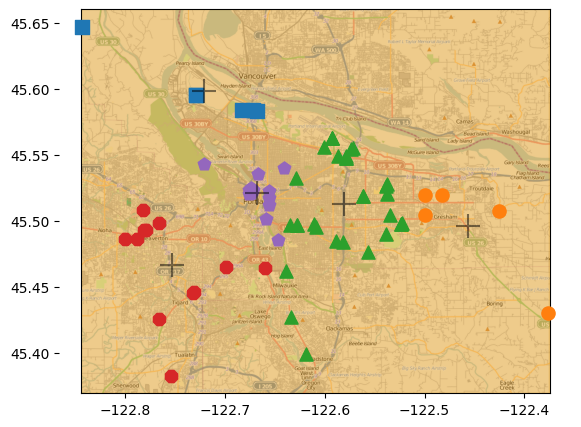

In [2]:
import portlandClubs
portlandClubs.clusterClubs()